In [0]:
import cv2
import dlib
import numpy as np
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import glob
import tensorflow as tf
from google.colab.patches import cv2_imshow
from sklearn.utils import shuffle
import math
import pickle
import copy
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import os

In [0]:
drive.mount('/content/gdrive')
!ls /content/gdrive

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
'My Drive'


In [0]:
# Copyright 2015-2016 Carnegie Mellon University
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Module for dlib-based alignment."""

import cv2
import dlib
import numpy as np

TEMPLATE = np.float32([
    (0.0792396913815, 0.339223741112), (0.0829219487236, 0.456955367943),
    (0.0967927109165, 0.575648016728), (0.122141515615, 0.691921601066),
    (0.168687863544, 0.800341263616), (0.239789390707, 0.895732504778),
    (0.325662452515, 0.977068762493), (0.422318282013, 1.04329000149),
    (0.531777802068, 1.06080371126), (0.641296298053, 1.03981924107),
    (0.738105872266, 0.972268833998), (0.824444363295, 0.889624082279),
    (0.894792677532, 0.792494155836), (0.939395486253, 0.681546643421),
    (0.96111933829, 0.562238253072), (0.970579841181, 0.441758925744),
    (0.971193274221, 0.322118743967), (0.163846223133, 0.249151738053),
    (0.21780354657, 0.204255863861), (0.291299351124, 0.192367318323),
    (0.367460241458, 0.203582210627), (0.4392945113, 0.233135599851),
    (0.586445962425, 0.228141644834), (0.660152671635, 0.195923841854),
    (0.737466449096, 0.182360984545), (0.813236546239, 0.192828009114),
    (0.8707571886, 0.235293377042), (0.51534533827, 0.31863546193),
    (0.516221448289, 0.396200446263), (0.517118861835, 0.473797687758),
    (0.51816430343, 0.553157797772), (0.433701156035, 0.604054457668),
    (0.475501237769, 0.62076344024), (0.520712933176, 0.634268222208),
    (0.565874114041, 0.618796581487), (0.607054002672, 0.60157671656),
    (0.252418718401, 0.331052263829), (0.298663015648, 0.302646354002),
    (0.355749724218, 0.303020650651), (0.403718978315, 0.33867711083),
    (0.352507175597, 0.349987615384), (0.296791759886, 0.350478978225),
    (0.631326076346, 0.334136672344), (0.679073381078, 0.29645404267),
    (0.73597236153, 0.294721285802), (0.782865376271, 0.321305281656),
    (0.740312274764, 0.341849376713), (0.68499850091, 0.343734332172),
    (0.353167761422, 0.746189164237), (0.414587777921, 0.719053835073),
    (0.477677654595, 0.706835892494), (0.522732900812, 0.717092275768),
    (0.569832064287, 0.705414478982), (0.635195811927, 0.71565572516),
    (0.69951672331, 0.739419187253), (0.639447159575, 0.805236879972),
    (0.576410514055, 0.835436670169), (0.525398405766, 0.841706377792),
    (0.47641545769, 0.837505914975), (0.41379548902, 0.810045601727),
    (0.380084785646, 0.749979603086), (0.477955996282, 0.74513234612),
    (0.523389793327, 0.748924302636), (0.571057789237, 0.74332894691),
    (0.672409137852, 0.744177032192), (0.572539621444, 0.776609286626),
    (0.5240106503, 0.783370783245), (0.477561227414, 0.778476346951)])

TPL_MIN, TPL_MAX = np.min(TEMPLATE, axis=0), np.max(TEMPLATE, axis=0)
MINMAX_TEMPLATE = (TEMPLATE - TPL_MIN) / (TPL_MAX - TPL_MIN)


class AlignDlib:
    """
    Use `dlib's landmark estimation <http://blog.dlib.net/2014/08/real-time-face-pose-estimation.html>`_ to align faces.
    The alignment preprocess faces for input into a neural network.
    Faces are resized to the same size (such as 96x96) and transformed
    to make landmarks (such as the eyes and nose) appear at the same
    location on every image.
    Normalized landmarks:
    .. image:: ../images/dlib-landmark-mean.png
    """

    #: Landmark indices.
    INNER_EYES_AND_BOTTOM_LIP = [39, 42, 57]
    OUTER_EYES_AND_NOSE = [36, 45, 33]

    def __init__(self, facePredictor):
        """
        Instantiate an 'AlignDlib' object.
        :param facePredictor: The path to dlib's
        :type facePredictor: str
        """
        assert facePredictor is not None

        self.detector = dlib.get_frontal_face_detector()
        self.predictor = dlib.shape_predictor(facePredictor)


        
    #Define preprocess here (OUR METHOD)
    def preprocessing(rgbimg):
        rgbimg = imutils.resize(rgbimg, height= 400,width=700)
        labimg = cv2.cvtColor(rgbimg, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(labimg)    
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        cl = clahe.apply(l)
        limg = cv2.merge((cl,a,b))
        final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

        return final


    def getAllFaceBoundingBoxes(self, rgbImg):
        """
        Find all face bounding boxes in an image.
        :param rgbImg: RGB image to process. Shape: (height, width, 3)
        :type rgbImg: numpy.ndarray
        :return: All face bounding boxes in an image.
        :rtype: dlib.rectangles
        """
        assert rgbImg is not None

        try:
            return self.detector(self.preprocessing(rgbImg), 1)
        except Exception as e:
            print("Warning: {}".format(e))
            # In rare cases, exceptions are thrown.
            return []

    def getLargestFaceBoundingBox(self, rgbImg, skipMulti=False):
        """
        Find the largest face bounding box in an image.
        :param rgbImg: RGB image to process. Shape: (height, width, 3)
        :type rgbImg: numpy.ndarray
        :param skipMulti: Skip image if more than one face detected.
        :type skipMulti: bool
        :return: The largest face bounding box in an image, or None.
        :rtype: dlib.rectangle
        """
        assert rgbImg is not None

        faces = self.getAllFaceBoundingBoxes(self.preprocessing(rgbImg))
        if (not skipMulti and len(faces) > 0) or len(faces) == 1:
            return max(faces, key=lambda rect: rect.width() * rect.height())
        else:
            return None

    def plot_circle(ax, center, radius, color):
        circle = plt.Circle(center, radius, facecolor=color, edgecolor='0.5')
        ax.add_patch(circle)


    def findLandmarks(self, rgbImg, bb):
        """
        Find the landmarks of a face.
        :param rgbImg: RGB image to process. Shape: (height, width, 3)
        :type rgbImg: numpy.ndarray
        :param bb: Bounding box around the face to find landmarks for.
        :type bb: dlib.rectangle
        :return: Detected landmark locations.
        :rtype: list of (x,y) tuples
        """
        assert rgbImg is not None
        assert bb is not None

        points = self.predictor(self.preprocessing(rgbImg), bb)
        return list(map(lambda p: (p.x, p.y), points.parts()))

    def align(self, imgDim, rgbImg, bb=None,
              landmarks=None, landmarkIndices=INNER_EYES_AND_BOTTOM_LIP,
              skipMulti=False):
        r"""align(imgDim, rgbImg, bb=None, landmarks=None, landmarkIndices=INNER_EYES_AND_BOTTOM_LIP)
        Transform and align a face in an image.
        :param imgDim: The edge length in pixels of the square the image is resized to.
        :type imgDim: int
        :param rgbImg: RGB image to process. Shape: (height, width, 3)
        :type rgbImg: numpy.ndarray
        :param bb: Bounding box around the face to align. \
                   Defaults to the largest face.
        :type bb: dlib.rectangle
        :param landmarks: Detected landmark locations. \
                          Landmarks found on `bb` if not provided.
        :type landmarks: list of (x,y) tuples
        :param landmarkIndices: The indices to transform to.
        :type landmarkIndices: list of ints
        :param skipMulti: Skip image if more than one face detected.
        :type skipMulti: bool
        :return: The aligned RGB image. Shape: (imgDim, imgDim, 3)
        :rtype: numpy.ndarray
        """
        assert imgDim is not None
        assert rgbImg is not None
        assert landmarkIndices is not None

        if bb is None:
            bb = self.getLargestFaceBoundingBox(rgbImg, skipMulti)
            if bb is None:
                return

        if landmarks is None:
            landmarks = self.findLBP(rgbImg, bb)

        npLandmarks = np.float32(landmarks)
        npLandmarkIndices = np.array(landmarkIndices)

        H = cv2.getAffineTransform(npLandmarks[npLandmarkIndices],
                                   imgDim * MINMAX_TEMPLATE[npLandmarkIndices])
        thumbnail = cv2.warpAffine(rgbImg, H, (imgDim, imgDim))

        return thumbnail


Trying to save LBP feature for every video, clips, frame by frame.

In [0]:
def load_BAUM_1(path,stereo = False, version = 'S'):

    if version == 'S' or version == 's': # spontaneous 
        df = pd.read_excel(os.path.join(path,"data/BAUM1spontaneous/Annotations_BAUM1s.xlsx"))
        subjects = glob.glob(os.path.join(path,"data/BAUM1spontaneous/BAUM1s_MP4_All/*"))
        csv_path = os.path.join(path,"data/BAUM1spontaneous/BAUM1s_landmarks/")

    elif version == 'A' or version == 'a': # acted 
        df = pd.read_excel (os.path.join(path,"data/BAUM1acted/Annotations_BAUM1a.xlsx"))
        subjects = glob.glob(os.path.join(path,"data/BAUM1acted/BAUM1a_MP4_all/*") )  
        csv_path = os.path.join(path, "data/BAUM1acted/BAUM1a_landmarks/")

    #Import labels and info
    BAUM_1_truth = df.iloc[:,1:8]
    #BAUM_1_info = df.iloc[:15,10:13]

    # read labels and the videos
    clips = []
    labels = []
    for i, subject in enumerate( subjects):

        videos = glob.glob(subject + '/*.mp4')
        #print(subject)
        for j, video in enumerate( videos):
            
            #assing the labels
            video_name = video[-12:-4]
            label = BAUM_1_truth[ BAUM_1_truth['Clip Name'] == video_name]

            if label.empty == False:
              #label = np.array( label)
              labels.append( np.array(label)[0])

              #assign clips
              clip = cv2.VideoCapture( video)
              clips.append( clip)

    landmarks= [] # Landmarklari track edip hepsini csv dosyasina yazdim surekli extract etmeyelim diye (onlari da ekliycem)

    #print('reading landmarks')
    for i, label in enumerate( labels):
        path = csv_path + label[2] + ".csv"
        current_csv = pd.read_csv( path) # import csv
        current_csv.columns = current_csv.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '') #normalize columns

        current_csv = np.array( current_csv)
            
        
        if stereo:
            lndmrk = current_csv[ :, 435:639]
        else:
            lndmrk = current_csv[ :, 299:435]
                
        landmarks.append(lndmrk)    
      
    return clips, np.array(labels), landmarks

In [0]:
path = "gdrive/My Drive/CS 554 : Computer Vision/visionprojectandsurvey/project/"

lbp_1s = load_lbp_fast(path)
for i in lbp_1s:
  print(len(i))

In [0]:

def generate_BAUM_2i(path): 
    predictor_path = os.path.join(path,"shape_predictor_68_face_landmarks.dat")
    mydlib = AlignDlib(predictor_path)
  
    #loading baum2i
    BAUM_2i_truth  = pd.read_excel (r (os.path.join(path,"data/BAUM2i/Annotations_for_images.xlsx")))

    
    frame_folder = os.path.join(path,"data/BAUM2i/BAUM_2i/")
    frame_names = glob.glob( frame_folder + '/*.tif')

    # read labels and the videos
    frames = []
    landmarks = []
    labels = []

    for i, name in enumerate( frame_names):

        image_name = name[-16:-8]
        label =  BAUM_2i_truth[ BAUM_2i_truth['Clip Name'] == image_name]

        if label.empty == False:
            img = cv2.imread(name)
            bb = mydlib.getLargestFaceBoundingBox(img, True)

            if bb is not None:
                lndmrk = mydlib.findLBP( img, bb)

                labels.append( np.array(label)[0])
                frames.append( img)
                landmarks.append( lndmrk)

    return frames, landmarks, labels

def show_landmarks(image, landmarks):
    plt.imshow(imgage)
    for l in landmarks:
        plt.plot(l[0],l[1],'r-o',markersize=2)  


def read_BAUM1a(path):
    with open(os.path.join(path,"fast_data/labels_1a.pickle"), 'rb') as f:
        labels_1a = pickle.load( f)

    with open(os.path.join(path,"fast_data/landmarks_1a.pickle"), 'rb') as f:
        landmarks_1a = pickle.load( f) 

    return labels_1a, landmarks_1a 


def read_BAUM1s(path):
    with open(os.path.join(path, "fast_data/labels_1s.pickle"), 'rb') as f:
        labels_1s = pickle.load(f)

    with open(os.path.join(path,"fast_data/landmarks_1s.pickle"), 'rb') as f:
        landmarks_1s = pickle.load( f) 


    return labels_1s, landmarks_1s


In [0]:

import numpy as np
#from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.optimizers import Adam
#from keras.applications.vgg16 import VGG16
#model = VGG16()
#print(model.summary())

Using TensorFlow backend.


In [0]:
def format_BAUM1( landmarks_1, labels_1, pad = False):
  L = len(landmarks_1)
  

  # extract sentiment 
  labels_1 = labels_1[:,3]

  # lowecase and fix typo labels 
  for i, a in enumerate( labels_1):  
    labels_1[i] = a.lower()
    
    #fix wrond labels 
    if labels_1[i] == 'contepmt':
      labels_1[i] = 'contempt'
    if labels_1[i] == 'sadnes':
      labels_1[i] = 'sadness'
    
  # One hot encode labels
  label_encoder = LabelEncoder()
  onehot_encoder = OneHotEncoder(sparse=False)
  labels_1 = label_encoder.fit_transform(labels_1)
  labels_1 = onehot_encoder.fit_transform( labels_1.reshape( len( labels_1), 1))


  # shuffle 
  landmarks_1,  labels_1 = shuffle( landmarks_1,  labels_1) 
  # Test train split 
  x_Train, x_Test, y_Train, y_Test = train_test_split(landmarks_1,  labels_1)


  # determine max sequence lenght
  max_len = 0
  for x in x_Train:
    if x.shape[0] > max_len:
      max_len = x.shape[0]
  for x in x_Test:
    if x.shape[0] > max_len:
      max_len = x.shape[0]

  #sequence_len = max_len
  sequence_len = 100

  if pad: 
    # pad sequence to maximum sequence lenght  
    x_Train = sequence.pad_sequences(x_Train, maxlen= sequence_len)
    x_Test = sequence.pad_sequences(x_Test, maxlen= sequence_len)
  
  return x_Train, x_Test, y_Train, y_Test


In [0]:

def window_2( labels, lbp):
  # window all sequences
  #adjusted for 0.5 second segments
  FRAMES_PER_SEGMENT = 30

  #Placeholder for resulting sequences
  new_labels = []
  new_landmarks = []
  new_lbp = []


  for i, l in enumerate( labels):
    no_of_segments = len(lbp[i])//FRAMES_PER_SEGMENT

    for j in range( no_of_segments):
      new_labels.append( labels[i])
     
      new_lbp.append( lbp[i][ j * FRAMES_PER_SEGMENT: (j+1) * FRAMES_PER_SEGMENT])

      if lbp[i][ j * FRAMES_PER_SEGMENT: (j+1) * FRAMES_PER_SEGMENT ].shape != (FRAMES_PER_SEGMENT,650):
        print(i)
        print(j, no_of_segments)

  return np.array(new_labels), new_lbp


In [0]:
path = "gdrive/My Drive/CS 554 : Computer Vision/visionprojectandsurvey/project"
labels_1s, landmarks_1s = read_BAUM1s(path)

x_Train, x_Test, y_Train, y_Test = format_BAUM1(lbp_1s, labels_1s)

y_Train, x_Train =window_2(y_Train, x_Train)
y_Test, x_Test = window_2(y_Test, x_Test )

In [0]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
from keras import backend as K 
img_width, img_height = 100, 136
if K.image_data_format() == 'channels_first': 
    input_shape = (1, img_width, img_height) 
else: 
    input_shape = (img_width, img_height, 1) 

def lr_scheduler(epoch, lr):
    decay_rate = 0.1
    decay_step = 90
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

In [0]:
from keras.applications.vgg16  import VGG16
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.optimizers import SGD
# snippet of using the LearningRateScheduler callback
from keras.callbacks import LearningRateScheduler

In [0]:
'''import numpy as np
import keras
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, labels, batch_size=32, dim=(1,None,650), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.data = data
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_data = [self.data[k] for k in indexes]
        list_label = [self.labels[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_data,list_label)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.data))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_data,list_label):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        
        X = [[np.empty((self.batch_size, *(1,650), self.n_channels))]]
        y = np.empty((self.batch_size), dtype=int)
        print(list_label)
        # Generate data
        for i, data in enumerate(list_data):
            # Store sample
            X[i].append(data) 
            # Store class
            #y[i] = list_label[i]


        return X, list_label
'''

"import numpy as np\nimport keras\nclass DataGenerator(keras.utils.Sequence):\n    'Generates data for Keras'\n    def __init__(self, data, labels, batch_size=32, dim=(1,None,650), n_channels=1,\n                 n_classes=10, shuffle=True):\n        'Initialization'\n        self.dim = dim\n        self.batch_size = batch_size\n        self.labels = labels\n        self.data = data\n        self.n_channels = n_channels\n        self.n_classes = n_classes\n        self.shuffle = shuffle\n        self.on_epoch_end()\n\n    def __len__(self):\n        'Denotes the number of batches per epoch'\n        return int(np.floor(len(self.data) / self.batch_size))\n\n    def __getitem__(self, index):\n        'Generate one batch of data'\n        # Generate indexes of the batch\n        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]\n\n        # Find list of IDs\n        list_data = [self.data[k] for k in indexes]\n        list_label = [self.labels[k] for k in indexes]\n 

In [0]:
'''def train_generator(x_Train,y_Train,batch_size):
  while True:
    start = 0
    end = batch_size
    while start < len(x_Train):
      t_data = x_Train[start:end]
      for i, a in enumerate(t_data):
        try:
          print("xtrain " + str(i) +"   "+ str(len(a)))
          yield a.reshape((1,len(a),650,1)), y_Train[i].reshape(1,13)
          
        except StopIteration as e:
          print(e)
          break
      start += batch_size
      end += batch_size


def test_generator(x_Test,y_Test,batch_size):
  while True:
    start = 0
    end = batch_size
    while start < len(x_Test):
      t_data = x_Test[start:end]
      for i, a in enumerate(t_data):
        try:
          print("xtest" + str(i) +"   "+ str(len(a)))
          yield a.reshape((1,len(a),650,1)), y_Test[i].reshape(1,13)
          
        except StopIteration as e:
          print(e)
          break
      start += batch_size
      end += batch_size
'''

'def train_generator(x_Train,y_Train,batch_size):\n  while True:\n    start = 0\n    end = batch_size\n    while start < len(x_Train):\n      t_data = x_Train[start:end]\n      for i, a in enumerate(t_data):\n        try:\n          print("xtrain " + str(i) +"   "+ str(len(a)))\n          yield a.reshape((1,len(a),650,1)), y_Train[i].reshape(1,13)\n          \n        except StopIteration as e:\n          print(e)\n          break\n      start += batch_size\n      end += batch_size\n\n\ndef test_generator(x_Test,y_Test,batch_size):\n  while True:\n    start = 0\n    end = batch_size\n    while start < len(x_Test):\n      t_data = x_Test[start:end]\n      for i, a in enumerate(t_data):\n        try:\n          print("xtest" + str(i) +"   "+ str(len(a)))\n          yield a.reshape((1,len(a),650,1)), y_Test[i].reshape(1,13)\n          \n        except StopIteration as e:\n          print(e)\n          break\n      start += batch_size\n      end += batch_size\n'

In [0]:
'''params = {'dim': (1,None,650),
          'batch_size': 64,
          'n_classes': 13,
          'n_channels': 1,
          'shuffle': True}


# Generators
train_generator = DataGenerator(x_Train, y_Train,  **params)
test_generator = DataGenerator(x_Test, y_Test,  **params)'''

"params = {'dim': (1,None,650),\n          'batch_size': 64,\n          'n_classes': 13,\n          'n_channels': 1,\n          'shuffle': True}\n\n\n# Generators\ntrain_generator = DataGenerator(x_Train, y_Train,  **params)\ntest_generator = DataGenerator(x_Test, y_Test,  **params)"

In [0]:
'''
def train_generator(x_Train,y_Train):
  while True:
    for i, a in enumerate(x_Train):
      try:
        print("xtrain " + str(i) +"   "+ str(len(a)))
        yield a.reshape((1,len(a),650,1)), y_Train[i].reshape(1,13)
        
      except StopIteration as e:
        print(e)
        break
def test_generator(x_Test,y_Test):
  while True:
    for i, a in enumerate(x_Test):
      try:
        print("xtest" + str(i) +"   "+ str(len(a)))
        yield a.reshape((1,len(a),650,1)), y_Test[i].reshape(1,13)
        
      except StopIteration as e:
        print(e)
        break'''

'\ndef train_generator(x_Train,y_Train):\n  while True:\n    for i, a in enumerate(x_Train):\n      try:\n        print("xtrain " + str(i) +"   "+ str(len(a)))\n        yield a.reshape((1,len(a),650,1)), y_Train[i].reshape(1,13)\n        \n      except StopIteration as e:\n        print(e)\n        break\ndef test_generator(x_Test,y_Test):\n  while True:\n    for i, a in enumerate(x_Test):\n      try:\n        print("xtest" + str(i) +"   "+ str(len(a)))\n        yield a.reshape((1,len(a),650,1)), y_Test[i].reshape(1,13)\n        \n      except StopIteration as e:\n        print(e)\n        break'

In [0]:
'''
from keras.preprocessing.image import ImageDataGenerator 
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPool2D ,Conv1D, MaxPool1D,GlobalMaxPooling1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Activation, Dropout, Flatten, Dense,LeakyReLU, TimeDistributed
from keras.layers import BatchNormalization,LSTM
from keras import backend as K 
import keras,os
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=32, kernel_size=2, activation='relu'), input_shape=(None,650,1)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(10, activation='relu'))
model.add(Dense(13,activation='softmax'))
learning_rate = 0.0001
decay_rate =0.0001
momentum = 0.9
opt = Adam(lr=learning_rate, decay=decay_rate)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()
'''

"\nfrom keras.preprocessing.image import ImageDataGenerator \nfrom keras.models import Sequential \nfrom keras.layers import Conv2D, MaxPool2D ,Conv1D, MaxPool1D,GlobalMaxPooling1D\nfrom keras.layers.convolutional import MaxPooling1D\nfrom keras.layers import Activation, Dropout, Flatten, Dense,LeakyReLU, TimeDistributed\nfrom keras.layers import BatchNormalization,LSTM\nfrom keras import backend as K \nimport keras,os\nmodel = Sequential()\nmodel.add(TimeDistributed(Conv1D(filters=32, kernel_size=2, activation='relu'), input_shape=(None,650,1)))\nmodel.add(TimeDistributed(MaxPooling1D(pool_size=2)))\nmodel.add(TimeDistributed(Flatten()))\nmodel.add(LSTM(10, activation='relu'))\nmodel.add(Dense(13,activation='softmax'))\nlearning_rate = 0.0001\ndecay_rate =0.0001\nmomentum = 0.9\nopt = Adam(lr=learning_rate, decay=decay_rate)\n\nmodel.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])\n\nmodel.summary()\n"

In [0]:
'''model.fit_generator(generator= train_generator(x_Train,y_Train),
            validation_data=test_generator(x_Test,y_Test),
            steps_per_epoch=64,
            validation_steps = 32,
            epochs=50,     
            callbacks = [LearningRateScheduler(lr_scheduler, verbose=1)],
            verbose=1) '''

'model.fit_generator(generator= train_generator(x_Train,y_Train),\n            validation_data=test_generator(x_Test,y_Test),\n            steps_per_epoch=64,\n            validation_steps = 32,\n            epochs=50,     \n            callbacks = [LearningRateScheduler(lr_scheduler, verbose=1)],\n            verbose=1) '

In [0]:
'''
learning_rate = 0.01
decay_rate = 5e-3
momentum = 0.9
opt = Adam(lr=learning_rate, decay=decay_rate)
#opt = SGD(lr=learning_rate,momentum=momentum, decay=decay_rate, nesterov=False)
xception_model = VGG16(
    include_top=True,
    input_tensor=None,
    input_shape= (250,260,1),
    weights= None,
    pooling=None,
    classes=13)

xception_model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])
xception_model.summary()
'''

"\nlearning_rate = 0.01\ndecay_rate = 5e-3\nmomentum = 0.9\nopt = Adam(lr=learning_rate, decay=decay_rate)\n#opt = SGD(lr=learning_rate,momentum=momentum, decay=decay_rate, nesterov=False)\nxception_model = VGG16(\n    include_top=True,\n    input_tensor=None,\n    input_shape= (250,260,1),\n    weights= None,\n    pooling=None,\n    classes=13)\n\nxception_model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])\nxception_model.summary()\n"

In [0]:
'''
checkpoint = ModelCheckpoint("xception", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

from keras.utils import to_categorical

xception_model.fit_generator(generator= train_generator(x_Train,y_Train),
            validation_data=test_generator(x_Test,y_Test),
            steps_per_epoch=64,
            validation_steps = 32,
            epochs=100,     
            callbacks = [LearningRateScheduler(lr_scheduler, verbose=1)],
            verbose=1) 
'''

'\ncheckpoint = ModelCheckpoint("xception", monitor=\'val_acc\', verbose=1, save_best_only=True, save_weights_only=False, mode=\'auto\', period=1)\nearly = EarlyStopping(monitor=\'val_acc\', min_delta=0, patience=20, verbose=1, mode=\'auto\')\n\nfrom keras.utils import to_categorical\n\nxception_model.fit_generator(generator= train_generator(x_Train,y_Train),\n            validation_data=test_generator(x_Test,y_Test),\n            steps_per_epoch=64,\n            validation_steps = 32,\n            epochs=100,     \n            callbacks = [LearningRateScheduler(lr_scheduler, verbose=1)],\n            verbose=1) \n'

In [0]:

'''
model.add(Conv2D(input_shape=input_shape,filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=13, activation="softmax"))
'''


'\nmodel.add(Conv2D(input_shape=input_shape,filters=64,kernel_size=(3,3),padding="same", activation="relu"))\nmodel.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))\nmodel.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))\nmodel.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))\nmodel.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))\nmodel.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))\nmodel.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))\nmodel.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))\nmodel.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))\nmodel.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))\nmodel.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))\nmodel.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))\nmodel.add(Conv2D(filters=512, kernel_size=(3,3

In [0]:
from keras.preprocessing.image import ImageDataGenerator 
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPool2D ,Conv1D, MaxPool1D,GlobalMaxPooling1D
from keras.layers.convolutional import MaxPooling1D
from keras.optimizers import Adam
from keras.layers import Activation, Dropout, Flatten, Dense,LeakyReLU, TimeDistributed
from keras.layers import BatchNormalization,LSTM
from keras import backend as K 
import keras,os

In [0]:
input_shape = (30,650)
model = Sequential()

'''
model.add(TimeDistributed(Conv1D(filters=32, kernel_size=2, activation='relu'), input_shape=input_shape))
model.add(TimeDistributed(Conv1D(filters=32, kernel_size=2, activation='relu')))
model.add(TimeDistributed(Dropout(0.2)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='relu')))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='relu')))
model.add(TimeDistributed(Dropout(0.2)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
'''

model.add(LSTM(120, activation='relu',recurrent_dropout= 0.25,input_shape=input_shape))
model.add(Dense(128))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.5))
model.add(Dense(256))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.5))
model.add(Dense(13,activation='softmax'))
learning_rate = 0.0001
decay_rate =0.0001
momentum = 0.9
opt = Adam(lr=learning_rate, decay=decay_rate)
opt = SGD(lr=learning_rate,momentum=0.9)
#model.build((None,) + input_shape)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 120)               370080    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               15488     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               33024     
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 256)              

In [0]:
batch_size = 64
history = model.fit( [x_Train],  [y_Train], validation_data = ([x_Test], [y_Test]), batch_size=batch_size, epochs=300)


Train on 3352 samples, validate on 1234 samples
Epoch 1/300
3352/3352 [==============================] - 4s 1ms/step - loss: 2.9740 - accuracy: 0.0800 - val_loss: 2.5424 - val_accuracy: 0.1370
Epoch 2/300
3352/3352 [==============================] - 3s 911us/step - loss: 2.7846 - accuracy: 0.1038 - val_loss: 2.5124 - val_accuracy: 0.1459
Epoch 3/300
3352/3352 [==============================] - 3s 904us/step - loss: 2.6594 - accuracy: 0.1325 - val_loss: 2.4848 - val_accuracy: 0.1532
Epoch 4/300
3352/3352 [==============================] - 3s 923us/step - loss: 2.5766 - accuracy: 0.1429 - val_loss: 2.4591 - val_accuracy: 0.1661
Epoch 5/300
3352/3352 [==============================] - 3s 902us/step - loss: 2.4912 - accuracy: 0.1730 - val_loss: 2.4408 - val_accuracy: 0.1613
Epoch 6/300
3352/3352 [==============================] - 3s 892us/step - loss: 2.4312 - accuracy: 0.1945 - val_loss: 2.4167 - val_accuracy: 0.1702
Epoch 7/300
3352/3352 [==============================] - 3s 898us/step -

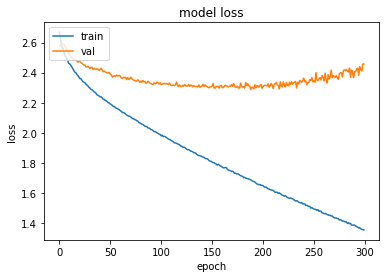

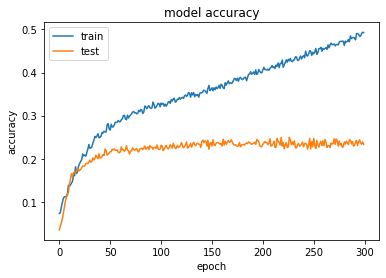

In [0]:
plt.plot(history.history['loss'])         # plot how loss changed with epocs on training data
plt.plot(history.history['val_loss'])     # plot how loss changes with epocs on test data
plt.title('model loss')                   # place titles
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])            # plot how accuracy changed with epocs on training data
plt.plot(history.history['val_accuracy'])        # plot how accuracy changes with epocs on test data
plt.title('model accuracy')                      # put labels
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
from sklearn.metrics import confusion_matrix

y_predict = model.predict_classes([x_Test])
print(y_predict)
ohe = OneHotEncoder()
y_Test2 = y_Test.dot(ohe.active_features_).astype(int)
print(y_Test2)
confusion_matrix(y_Test, y_predict)

In [0]:

'''

def train_generator(x_Train,y_Train):
  while True:
    for i, a in enumerate(x_Train):
      try:
        print("xtrain " + str(i) +"   "+ str(len(a)))
        yield a.reshape((1,len(a),650,1)), y_Train[i].reshape(1,13)
        
      except StopIteration as e:
        print(e)
        break
def test_generator(x_Test,y_Test):
  while True:
    for i, a in enumerate(x_Test):
      try:
        print("xtest" + str(i) +"   "+ str(len(a)))
        yield a.reshape((1,len(a),650,1)), y_Test[i].reshape(1,13)
        
      except StopIteration as e:
        print(e)
        break
'''

'\n\ndef train_generator(x_Train,y_Train):\n  while True:\n    for i, a in enumerate(x_Train):\n      try:\n        print("xtrain " + str(i) +"   "+ str(len(a)))\n        yield a.reshape((1,len(a),650,1)), y_Train[i].reshape(1,13)\n        \n      except StopIteration as e:\n        print(e)\n        break\ndef test_generator(x_Test,y_Test):\n  while True:\n    for i, a in enumerate(x_Test):\n      try:\n        print("xtest" + str(i) +"   "+ str(len(a)))\n        yield a.reshape((1,len(a),650,1)), y_Test[i].reshape(1,13)\n        \n      except StopIteration as e:\n        print(e)\n        break\n'